In [1]:
from keras import models
from keras import layers
from keras.datasets import boston_housing

Load data

In [2]:
(train_data, train_targets), (test_data, test_targets) = \
    boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


Prepare data

We should normoalize the data from different unit or category data

In this we using Z-score（Standardization), which mean = 0 and standerdiviation = 1

In [3]:
mean = train_data.mean(axis=0) # align the row
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

Construct the network

In [4]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu',
                       input_shape = (train_data.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mse',
              metrics = ['mae'])

K-fold cross validation

In [5]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print(f'processing fold {i}')
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                        train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                        train_targets[(i + 1) * num_val_samples:]],
                                        axis=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    # print(history.history)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

processing fold 0
processing fold 1
processing fold 2
processing fold 3


Plot validation score

In [6]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point *(1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Remove the first 10 pieces of data
smooth_mae_history = smooth_curve(average_mae_history[10:])

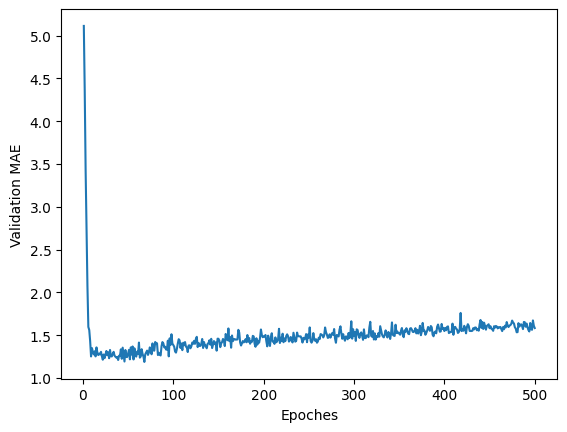

In [7]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epoches')
plt.ylabel('Validation MAE')
plt.show()

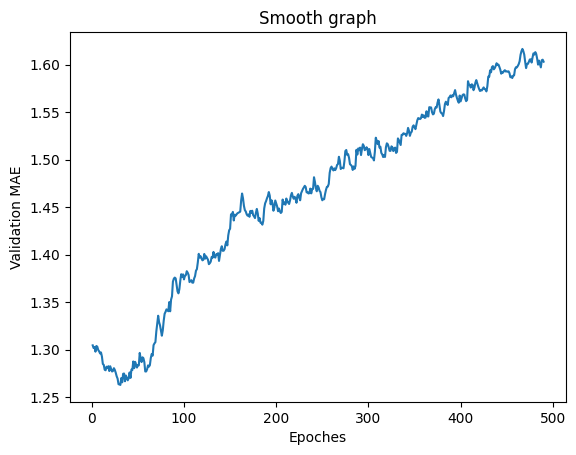

In [8]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.title('Smooth graph')
plt.xlabel('Epoches')
plt.ylabel('Validation MAE')
plt.show()

In [9]:
test_score, test_mae_score = model.evaluate(test_data, test_targets)
print('test_score = ', test_score)
print('test_mae_score = ', test_mae_score)

4/4 [==============================] - 0s 2ms/step - loss: 18.1424 - mae: 2.8151
test_score =  18.14238166809082
test_mae_score =  2.8150789737701416
